# Pytorch Hooks

<img src="hooks.jpg" alt="image of hooks" width="250">

Today, we will go over Pytorch hooks. Hooks are callbacks, just functions that are called at a specific time. This blog is based on Practical Deep Learning [lesson 16](https://course.fast.ai/Lessons/lesson16.html) and [the notebook](https://github.com/fastai/course22p2/blob/master/nbs/10_activations.ipynb). With hooks, we will see how our models are trained.

First, we setup environments.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/'Colab Notebooks'

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


In [ ]:
!pip -q install torcheval
!pip -q install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 11.6 MB/s eta 0:00:00


In [ ]:
#|export
from __future__ import annotations
import random,math,torch,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from functools import partial

from miniai.datasets import *
from miniai.learner import *

In [ ]:
import torch.nn.functional as F,matplotlib as mpl
from pathlib import Path
from operator import attrgetter,itemgetter
from contextlib import contextmanager

from torch import tensor,nn,optim
import torchvision.transforms.functional as TF
from datasets import load_dataset

from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['figure.constrained_layout.use'] = True

import logging
logging.disable(logging.WARNING)

In [ ]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)
bs = 1024

@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=2)
dt = dls.train
xb, yb = next(iter(dt))
xb.shape, yb[:10]

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

(torch.Size([1024, 1, 28, 28]), tensor([0, 6, 5, 2, 0, 0, 9, 1, 3, 8]))

We will set a random number generator (RNG) seed to make results reproducible. This is not useful for production but helpful when learning and debugging.

In [ ]:
#|export
def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

## Baseline

We will start using convolutional network.

In [ ]:
def conv(inp, outp, ks=3, stride=2, act=nn.ReLU()):
    res = nn.Conv2d(inp, outp, ks, stride, padding=ks//2)
    if act is not None: return nn.Sequential(res, act)
    return res

In [ ]:
conv(1, 3)

Sequential(
  (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)

In [ ]:
conv(1, 3, act=None)

Conv2d(1, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))

`cnn_layers` is a fundamental convolutional neural net. The height and width of the pixel sizes get halved each layer because we are using `stride=2`. As a result, the total number of activations is decreased by four times.

In [ ]:
def cnn_layers():
    return [                     # Pixel sizes
        conv(1, 8, ks=5),        # 14x14
        conv(8, 16),             # 7x7
        conv(16, 32),            # 4x4
        conv(32, 64),            # 2x2
        conv(64, 10, act=None),  # 1x1
        nn.Flatten()
    ]

In [ ]:
cnn_layers()

[Sequential(
   (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
   (1): ReLU()
 ),
 Sequential(
   (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): ReLU()
 ),
 Sequential(
   (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): ReLU()
 ),
 Sequential(
   (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): ReLU()
 ),
 Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
 Flatten(start_dim=1, end_dim=-1)]

In [ ]:
from torcheval.metrics import MulticlassAccuracy
metrics = MetricsCB(accuracy=MulticlassAccuracy(device='cpu'))
cbs = [metrics, TrainCB(), ProgressCB(plot=True), DeviceCB()]

In [ ]:
def fit(model, epoch=1, xtr_cbs=[]):
    learn = MomentumLearner(model, dls, F.cross_entropy, 0.6, cbs=cbs+xtr_cbs)
    learn.fit(epoch)
    return learn

accuracy,loss,epoch,train
0.143,2.358,0,train
0.100,2.304,0,eval


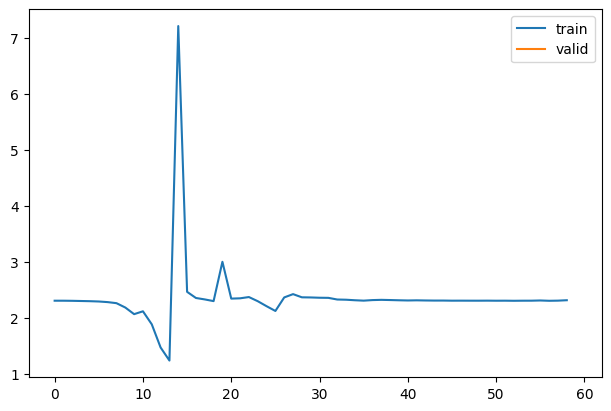

1

In [ ]:
set_seed(1)
fit(nn.Sequential(*cnn_layers()))

As we can see from the graph, it is not training well. But why does it not train well? To learn more about what's happening, we can look into the activations of each layer. Ideally, we want each layer to have a mean of 0 and a standard deviation of 1 because that's when numbers are accurate in computers. If the number gets too small or too big, we lose the accuracy of the values. So we might have activations that are too big or too small in this case.

## Manual hooks

Let's look at each layer's activations by manually saving the values of each layer.

In [ ]:
class Sequential(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.means = [[] for _ in layers]
        self.stds = [[] for _ in layers]

    def forward(self, x):
        for i, l in enumerate(self.layers):
            x = l(x)
            self.means[i].append(to_cpu(x).mean())
            self.stds[i].append(to_cpu(x).std())
        return x

accuracy,loss,epoch,train
0.143,2.358,0,train
0.100,2.304,0,eval


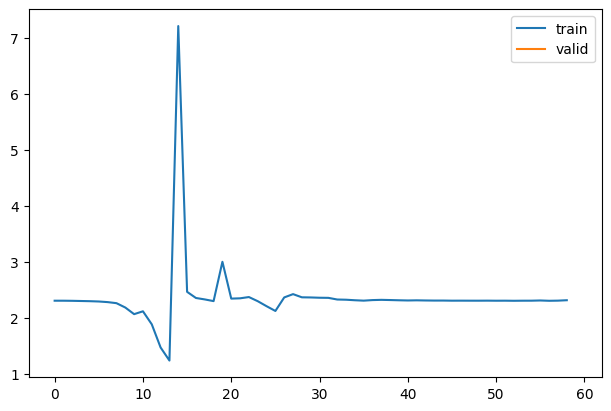

1

In [ ]:
set_seed(1)
model = Sequential(cnn_layers())
fit(model)

We are only interested in the first five layers because the last layer is `flatten`.

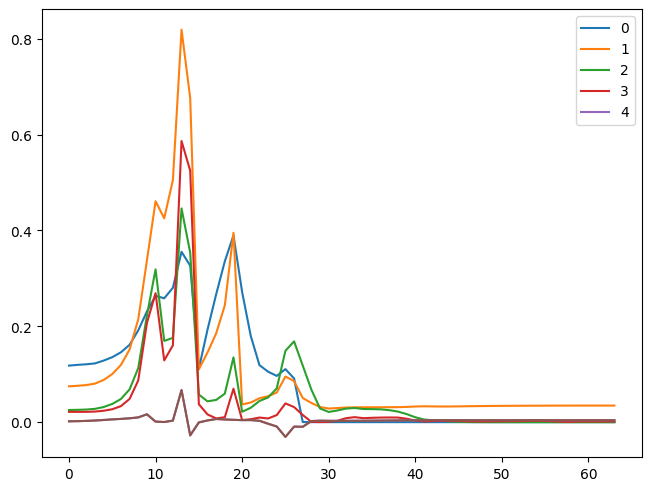

In [ ]:
for l in model.means:
    plt.plot(l)
plt.legend(range(5));

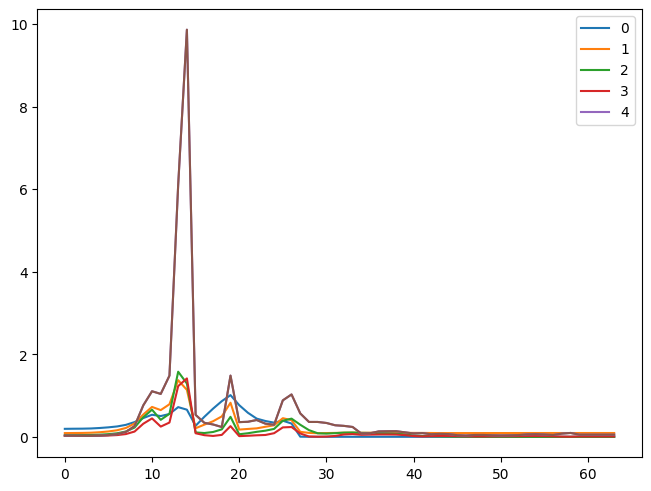

In [ ]:
for l in model.stds:
    plt.plot(l)
plt.legend(range(5));

So, we can see that our activations do not have a mean of 0 and a standard deviation of 1. This information is helpful, but we can get this info conveniently by using pytorch hooks.

## Pytorch hooks

In [ ]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

In [ ]:
means = [[] for _ in model]
stds = [[] for _ in model]
hooks = []

In [ ]:
def get_stats(i, mod, inp, outp):
    x = to_cpu(outp)
    means[i].append(x.mean())
    stds[i].append(x.std())

This is how we use Pytorch hooks. A hook takes module, input, and output as parameters. With `get_stats`, we also pass `i` to append stats into the correct one. Forward hooks are functions called after forward computation, just like callbacks.

In [ ]:
for i, l in enumerate(model): hooks.append(l.register_forward_hook(partial(get_stats, i)))

When we register a hook, we get a removable handle. We can save these in the `hooks` list and remove them after we are done. If we do not remove them, they will remain in the memory forever.

In [ ]:
hooks

accuracy,loss,epoch,train
0.143,2.358,0,train
0.100,2.304,0,eval


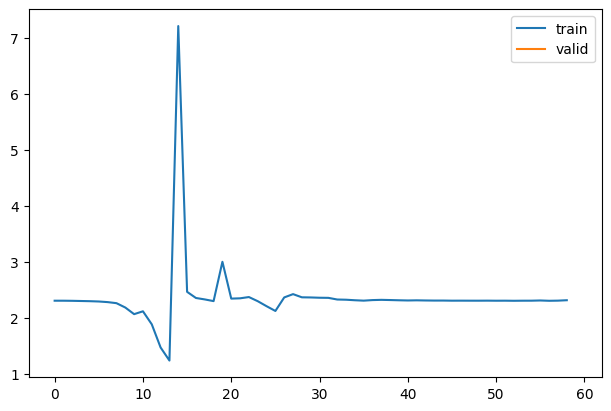

1

In [ ]:
fit(model)

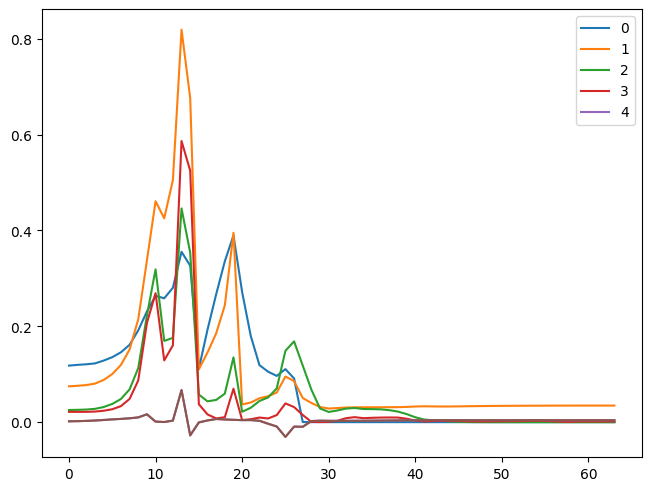

In [ ]:
for m in means: plt.plot(m)
plt.legend(range(5));

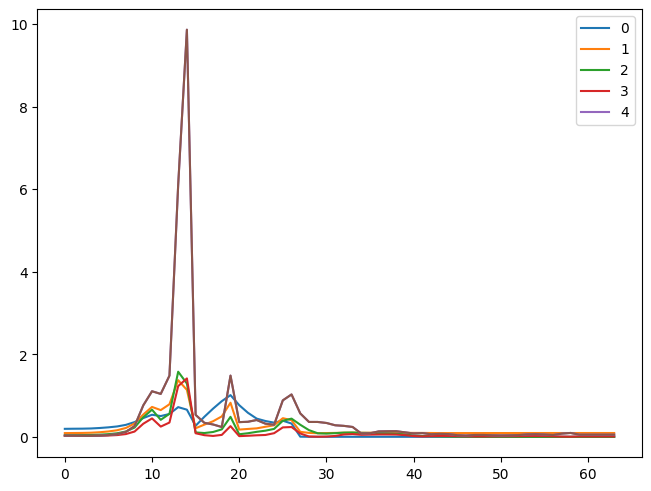

In [ ]:
for s in stds: plt.plot(s)
plt.legend(range(5));

In [ ]:
for h in hooks: h.remove()

By using `remove`, we can remove hooks.

## Hook class

Using global variables to store activation means and standard deviations is not ideal. So, let's create a `Hook` class to keep these variables. Also, we can easily remove hooks.

In [ ]:
class Hook:
    def __init__(self, layer, f): self.hook = layer.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

In [ ]:
def get_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = [[], []]
    x = to_cpu(outp)
    hook.stats[0].append(x.mean())
    hook.stats[1].append(x.std())

In [ ]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

In [ ]:
hooks = [Hook(l, get_stats) for l in model]

accuracy,loss,epoch,train
0.143,2.358,0,train
0.100,2.304,0,eval


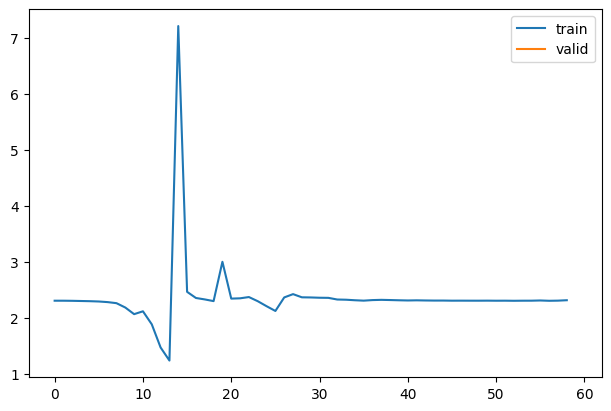

1

In [ ]:
fit(model)

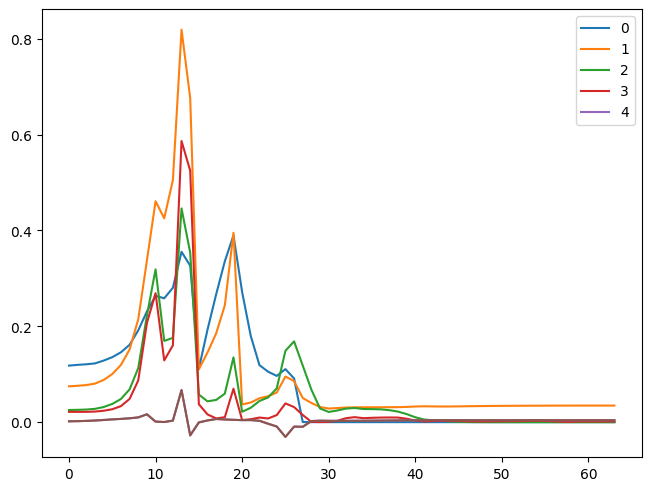

In [ ]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(5));

It's great that we can store all the stats in each `Hook` class, but we still have to create hooks as a global variable. We can create a `Hooks` class for that.

## Hooks class

Let's create a `Hooks` class. We will add some features. We will subclass `list` to use indexing and looping capabilities. Also, we add `__enter__` and `__exit__` to use a context manager. When done with the context manager, it will automatically remove the hooks to free memory.

In [ ]:
class Hooks(list):
    def __init__(self, f, model): super().__init__([Hook(l, f) for l in model])
    def __enter__(self): return self
    def __exit__(self, *args, **kwargs): self.remove()
    def remove(self):
        for h in self: h.remove()
    def __del__(self): self.remove()
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)

In [ ]:
hooks = Hooks(get_stats, model)
hooks

In [ ]:
del hooks[0]
hooks

In [ ]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

accuracy,loss,epoch,train
0.143,2.358,0,train
0.100,2.304,0,eval


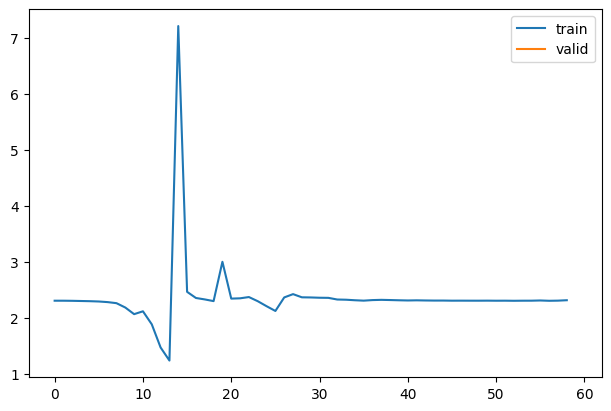

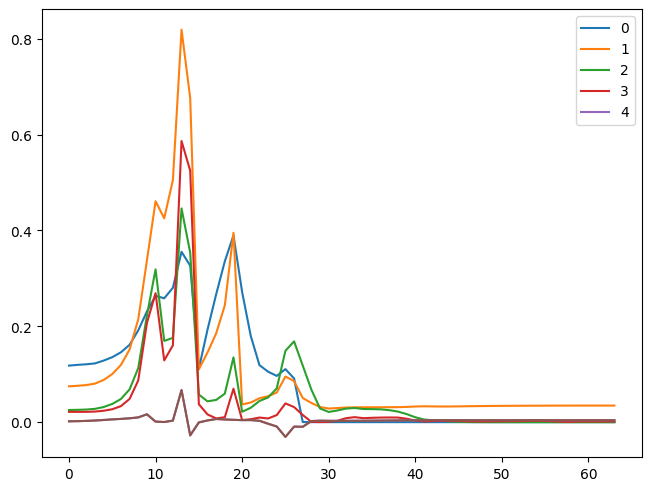

In [ ]:
with Hooks(get_stats, model) as hooks:
    fit(model)
    for h in hooks:
        plt.plot(h.stats[0])
    plt.legend(range(5))

## HooksCallback    

We can create a callback version of hooks.

In [ ]:
class HooksCB(Callback):
    def __init__(self, f):
        self.hook_fn = f

    def before_fit(self, learn):
        # setup hooks
        self.hooks = Hooks(self.hook_fn, learn.model)

    def after_fit(self, learn):
        # remove hooks
        for h in self.hooks: h.remove()

accuracy,loss,epoch,train
0.143,2.358,0,train
0.100,2.304,0,eval


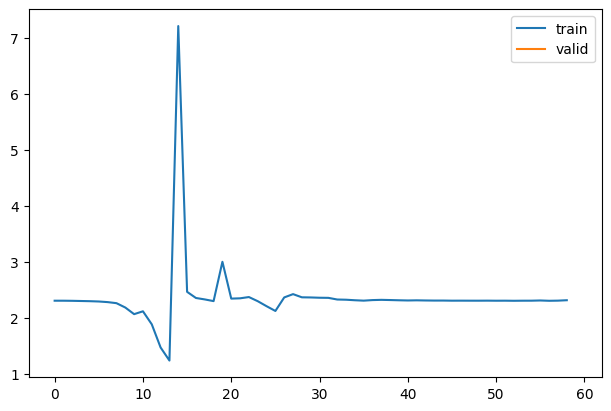

1

In [ ]:
set_seed(1)
hookscb = HooksCB(get_stats)
model = nn.Sequential(*cnn_layers())
fit(model, xtr_cbs=[hookscb])

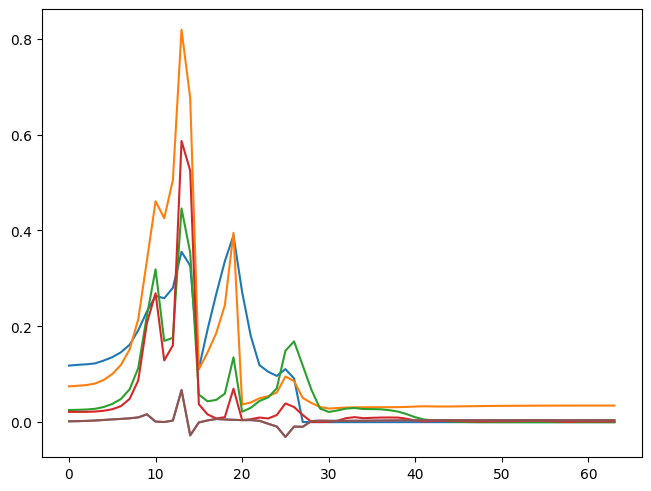

In [ ]:
for h in hookscb.hooks: plt.plot(h.stats[0])

## Histograms

Another exciting tool we can use to look at stats is a histogram. We create a histogram from activations with 50 bins from 0 to 10. We store this information in each hook as we did with means and standard deviations. By looking at the histogram, we can see how many activations are close to zero.

In [ ]:
def get_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = [[], [], []]
    x = to_cpu(outp)
    hook.stats[0].append(x.mean())
    hook.stats[1].append(x.std())
    hook.stats[2].append(x.abs().histc(50, 0, 10))

accuracy,loss,epoch,train
0.143,2.358,0,train
0.100,2.304,0,eval


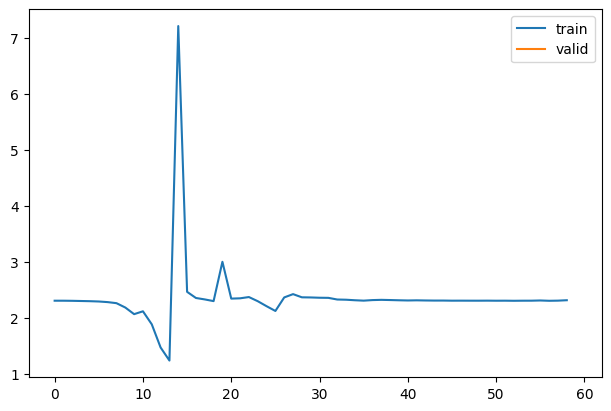

In [ ]:
set_seed(1)
hookscb = HooksCB(get_stats)
model = nn.Sequential(*cnn_layers())
fit(model, xtr_cbs=[hookscb])

In [ ]:
torch.stack(hookscb.hooks[0].stats[2]).t()

tensor([[1297868., 1294422., 1291560.,  ..., 3211258., 3211260., 2834941.],
        [ 154261.,  153682.,  155513.,  ...,       6.,       4.,       3.],
        [  89054.,   91588.,   90978.,  ...,       0.,       0.,       0.],
        ...,
        [      0.,       0.,       0.,  ...,       0.,       0.,       0.],
        [      0.,       0.,       0.,  ...,       0.,       0.,       0.],
        [      0.,       0.,       0.,  ...,       0.,       0.,       0.]])

Because the numbers are too big, we apply `log1p`, the same thing as adding one and taking a log because there are zeros.

In [ ]:
torch.stack(hookscb.hooks[0].stats[2]).t().log1p()

tensor([[14.08, 14.07, 14.07,  ..., 14.98, 14.98, 14.86],
        [11.95, 11.94, 11.95,  ...,  1.95,  1.61,  1.39],
        [11.40, 11.43, 11.42,  ...,  0.00,  0.00,  0.00],
        ...,
        [ 0.00,  0.00,  0.00,  ...,  0.00,  0.00,  0.00],
        [ 0.00,  0.00,  0.00,  ...,  0.00,  0.00,  0.00],
        [ 0.00,  0.00,  0.00,  ...,  0.00,  0.00,  0.00]])

In [ ]:
torch.stack(hookscb.hooks[0].stats[2]).t().shape

torch.Size([50, 64])

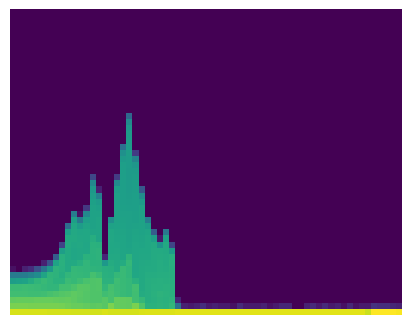

In [ ]:
histogram = torch.stack(hookscb.hooks[0].stats[2]).t()
show_image(histogram.log1p(), origin='lower', figsize=(4,4));

In the histogram, each pixel other than dark blue indicates some values other than 0. High value indicates yellow and green means low number. From the histogram, almost all activations are zeros starting from the beginning. Then, some activation values spike up couple times and drops to zero. Ideally, we want to get even yellow histogram up to about 10% of the height. That means most of the absolute value of activations are between zero and one, which is a good sign.

We can focus on how many absolute value of activations are smaller than 0.2. These are basically dead or almost dead, which means these numbers are not doing anything. We can plot the percentage of them from the total.

In [ ]:
histogram[0], histogram

(tensor([1297868., 1294422., 1291560., 1291628., 1283061., 1273476., 1256431., 1242345., 1212113., 1191507., 1177972., 1177066., 1174616.,
         1157383., 1168056., 1375630., 1218830., 1208255., 1204717., 1204226., 1228218., 1414853., 1474184., 1477038., 1477273., 1472988.,
         1477866., 1605349., 1605629., 1605630., 1605629., 1605626., 1605630., 1605629., 1605630., 1605630., 1605631., 1605627., 1605630.,
         1605630., 1605630., 1605629., 1605631., 1605630., 1605628., 1605628., 1605632., 1605632., 1605629., 1605627., 1605630., 1605627.,
         1605630., 1605629., 1605631., 1605628., 1605631., 1605630.,  953342., 3211256., 3211258., 3211258., 3211260., 2834941.]),
 tensor([[1297868., 1294422., 1291560.,  ..., 3211258., 3211260., 2834941.],
         [ 154261.,  153682.,  155513.,  ...,       6.,       4.,       3.],
         [  89054.,   91588.,   90978.,  ...,       0.,       0.,       0.],
         ...,
         [      0.,       0.,       0.,  ...,       0.,       0.,   

In [ ]:
histogram.sum(0)

tensor([1605632., 1605632., 1605632., 1605632., 1605632., 1605632., 1605632., 1605632., 1605632., 1605632., 1605632., 1605632., 1605632.,
        1605632., 1605632., 1605632., 1605632., 1605632., 1605632., 1605632., 1605632., 1605632., 1605632., 1605632., 1605632., 1605632.,
        1605632., 1605632., 1605632., 1605632., 1605632., 1605632., 1605632., 1605632., 1605632., 1605632., 1605632., 1605632., 1605632.,
        1605632., 1605632., 1605632., 1605632., 1605632., 1605632., 1605632., 1605632., 1605632., 1605632., 1605632., 1605632., 1605632.,
        1605632., 1605632., 1605632., 1605632., 1605632., 1605632.,  953344., 3211264., 3211264., 3211264., 3211264., 2834944.])

In [ ]:
histogram[0] / histogram.sum(0)

tensor([0.81, 0.81, 0.80, 0.80, 0.80, 0.79, 0.78, 0.77, 0.75, 0.74, 0.73, 0.73, 0.73, 0.72, 0.73, 0.86, 0.76, 0.75, 0.75, 0.75, 0.76, 0.88,
        0.92, 0.92, 0.92, 0.92, 0.92, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00,
        1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00])

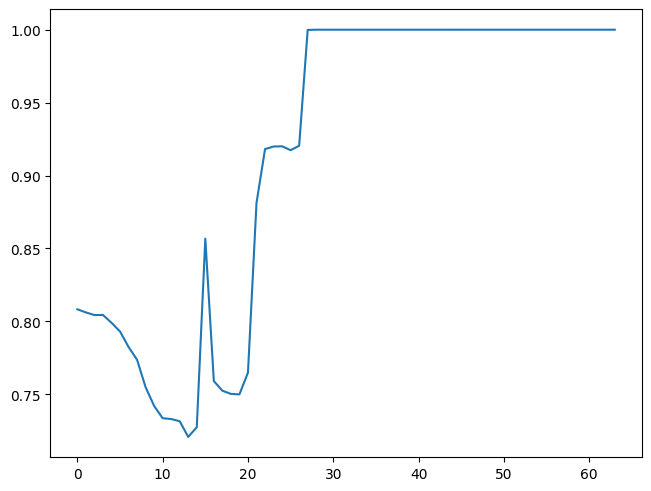

In [ ]:
plt.plot(histogram[0] / histogram.sum(0));

We can easily look at how bad this is.

## Conclusion

In this blog, we used Pytorch hooks to look into statistics of activations. They are basically functions with fancy names, like callbacks. Then, we created `Hook` class and `Hooks` class to avoid using global variables. We also created a version for a callback. Lastly, we looked at histogram and plots for zeroes. With those tools, we can see how well our models are training later and find out which initializing strategies work the best.